In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 1000
x_dim = 784 # 28 * 28
z_dim = 2

In [3]:
# Load training data from tf.keras
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()

print('train_images shape:', train_images.shape)


train_images shape: (60000, 28, 28)


In [4]:
# 앞에서부터 N개 데이터 취하고 flatten
samples = train_images[:N].reshape([-1, x_dim])
samples = samples / 256
print(samples.shape)

targets = train_labels[:N]
print(targets.shape)


(1000, 784)
(1000,)


### Visualization

In [5]:
def vector2image(vector):
    '''
    1D로 flatten된 vector를 2D image로 다시 되돌려 놓습니다.
    '''
    
    # vector의 rank가 1인 경우(batch가 아닌 경우)
    if len(vector.shape) == 1:
        image = vector.reshape(28, 28)
        
    # vector의 rank가 2인 경우(batch인 경우)
    elif len(vector.shape) == 2:
        image = vector.reshape(len(vector), 28, 28)
        
    return image


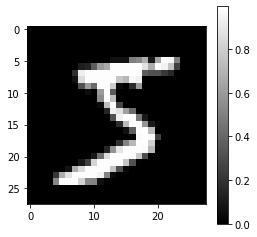

In [6]:
plt.figure(figsize=[4, 4])
plt.imshow(vector2image(samples[0]), cmap='gist_gray')
plt.colorbar()
plt.show()

### E-step

$\begin{aligned}
&p_{\theta}(z | x)=N\left(z | M^{-1} W^{T}(x-\mu), \sigma^{2} M^{-1}\right)\\
&\text { where } M=W^{T} W+\sigma^{2} I
\end{aligned}$

In [7]:
def E_step(W, mu, variance, samples):
    '''
    posterior distribution의 parameter들을 구합니다.
    
    arguments
    W       : (x_dim, z_dim), linear transform weight 
    mu      : (x_dim), linear transform bias (sample mean)
    variance: scalar, sample variance
    samples : (N, x_dim), dataset
    
    returns
    posterior_means: (N, z_dim), the mean of the posterior distribution
    posterior_covs : (z_dim, z_dim), the covariance matrix of the posterior distribution
    '''
    
    # shape: (z_dim, z_dim)
    M = W.T @ W + variance * np.eye(2)
    # shape: (z_dim, z_dim)
    M_inv = np.linalg.inv(M)
    
    # shape: (z_dim, N)
    posterior_means = M_inv @ W.T @ (samples - mu[None, :]).T
    # shape: (N, z_dim)
    posterior_means = posterior_means.T
    
    # shape: [z_dim, z_dim]
    posterior_covs = variance * M_inv
    
    return posterior_means, posterior_covs
    

### M-step

#### Weight update

$\begin{aligned}
&W_{n e w}=\left[\sum_{n=1}^{N}\left(x_{n}-\bar{x}\right) E\left[z_{n}\right]^{T}\right]\left[\sum_{n=1}^{N} E\left[z_{n} z_{n}^{T}\right]\right]^{-1}\\
&\text { where } E\left[z_{n} z_{n}^{T}\right]=\sigma^{2} M^{-1}+E\left[z_{n}\right] E\left[z_{n}\right]^{T}
\end{aligned}$

In [8]:

def find_new_W(samples, mu, posterior_means, correlations):
    '''
    W를 업데이트합니다.
    
    arguments
    samples        : (N, x_dim), the dataset
    mu             : (x_dim), linear transform bias (sample mean)
    posterior_means: (N, z_dim), the mean of the posterior distribution
    correlations   : (N, z_dim, z_dim), the correlations of z_n, E[z_n@z_n^T]
        
    returns
    W: (x_dim, z_dim), the linear transform weight
    '''
    
    # shape: (x_dim, z_dim)
    A = (samples - mu[None, :]).T @ posterior_means
    
    # shape: (z_dim, z_dim)
    B = np.linalg.inv(np.sum(correlations, axis=0))
    
    # shape: (x_dim, z_dim)
    new_W = A @ B
    
    return new_W



#### variance update
$\begin{aligned}
&\sigma_{n e w}^{2}=\frac{1}{N D} \sum_{n=1}^{N}\left\{\left\|x_{n}-\bar{x}\right\|^{2}-2 E\left[z_{n}\right]^{T} W_{n e w}^{T}\left(x_{n}-\bar{x}\right)+\operatorname{Tr}\left(E\left[z_{n} z_{n}^{T}\right] W_{n e w}^{T} W_{n e w}\right)\right\}\\
&\text { where } E\left[z_{n} z_{n}^{T}\right]=\sigma^{2} M^{-1}+E\left[z_{n}\right] E\left[z_{n}\right]^{T}
\end{aligned}$

In [9]:
def find_new_variance(samples, mu, posterior_means, correlations, new_W):
    '''
    variance를 업데이트합니다.
    
    arguments
    samples        : (N, x_dim), dataset
    mu             : (x_dim), linear transform bias (sample mean)
    posterior_means: (N, z_dim), the mean of the posterior distribution
    correlations   : (N, z_dim, z_dim), the correlations of z_n, E[z_n@z_n^T]
    new_W          : (x_dim, z_dim), the updated linear transform weight
        
    returns
    new_variance: scalar, the updated variance of the Gaussian distribution in the X-space
    '''
    
    sum_ = 0
    for n in range(N):
        # shape: scalar
        A = np.sum((samples[n] - mu) ** 2)

        # shape: (1, 1)
        B = 2 * posterior_means[n][None, :] @ new_W.T @ (samples[n] - mu)[:, None]
        # shape: scalar
        B = B[0, 0]
        
        # shape: scalar
        C = np.trace(correlations[n] @ new_W.T @ new_W)
        
        sum_ += (A - B + C)

    new_variance = sum_ / (N * x_dim)
    
    return new_variance



In [10]:
def M_step(posterior_means, posterior_covs, samples, mu):
    '''
    posterior를 바탕으로 parameter W, mu, variance를 업데이트 합니다.
    
    arguments
    posterior_means: (N, z_dim), the mean of the posterior distribution
    posterior_covs : (z_dim, z_dim), the covariance matrix of the posterior distribution
    samples        : (N, x_dim), the dataset
    mu             : (x_dim), the linear transform bias (sample mean)
    
    returns
    new_W       : (x_dim, z_dim), the updated linear transform weight
    new_variance: scalar, the updated variance of the Gaussian distribution in the X-space
    
    '''
    
    # shape: (N, z_dim, z_dim), E[z_n@z_n^T]
    correlations = posterior_covs + posterior_means[:, :, None] @ posterior_means[:, :, None].transpose(0, 2, 1)
    
    new_W = find_new_W(samples, mu, posterior_means, correlations)
    new_variance = find_new_variance(samples, mu, posterior_means, correlations, new_W)
    
    return new_W, new_variance
    
    

### EM iteration

In [11]:
from tqdm import tqdm_notebook as tqdm

# Parameter Initialization
# Weight
W = np.random.randn(x_dim, z_dim) * 0.01

# Bias (trivial solution)
mu = np.mean(samples, axis=0)

# variance 
variance = 0.01

for step in tqdm(range(100)):
    posterior_means, posterior_covs = E_step(W, mu, variance, samples)
    W, variance = M_step(posterior_means, posterior_covs, samples, mu)
    

### Embedding Visualization

In [12]:
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

(1000, 2)


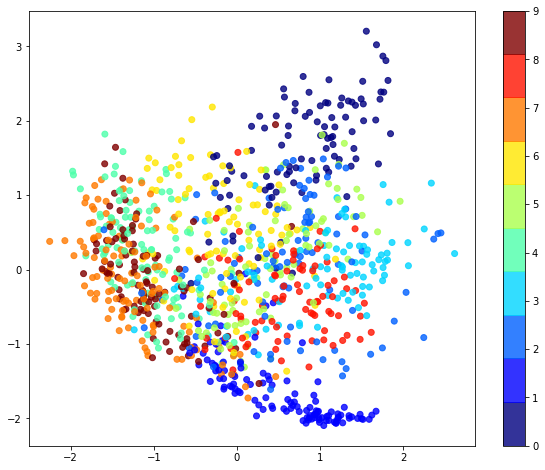

In [13]:
from numpy.linalg import inv

M = W.T @ W + variance * np.eye(z_dim)
M_inv = inv(M)

Z = []
labels = []
for index in range(0, len(samples)):
    x = samples[index]
    z = M_inv @ W.T @ (x - mu)
    Z.append(z)
    labels.append(targets[index])
    
Z = np.stack(Z)
labels = np.stack(labels)

print(Z.shape)

plt.figure(figsize=[10, 8])
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap=discrete_cmap(10, 'jet'), alpha=0.8)
plt.colorbar()
plt.show()

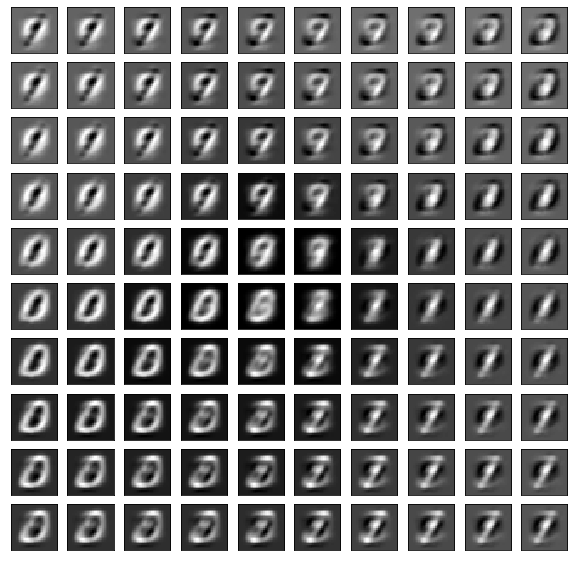

In [14]:
x_grid = np.linspace(-4, 4, 10)
y_grid = np.linspace(4, -4, 10)
xv, yv = np.meshgrid(x_grid, y_grid)
Z = np.stack([xv, yv], axis=2)

plt.figure(figsize=[10, 10])
for x_index in range(10):
    for y_index in range(10):
        z = Z[x_index][y_index]
        x = (W @ z + mu)
        
        plt.subplot(10, 10, x_index + 1 + y_index * 10)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(vector2image(x), cmap='gray')
        
plt.show()